# Application

```{contents}
:local:
```

Some code snippets are modified from {cite}`foundations_of_data_science_with_python_2021` for my experimentation!

## Utilities

In [ ]:
from __future__ import annotations

import sys
from pathlib import Path
from typing import Sequence, Optional
import rich
from IPython.display import HTML, display

import math

import matplotlib.pyplot as plt
from IPython.display import display

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

def find_root_dir(current_path: Path | None = None, marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path | None
        The starting path to search from. If None, the current working directory
        `Path.cwd()` is used.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path | None
        The path to the root directory. Returns None if the marker is not found.
    """
    if not current_path:
        current_path = Path.cwd()
    current_path = current_path.resolve()
    for parent in [current_path, *current_path.parents]:
        if (parent / marker).exists():
            return parent
    return None

current_file_path = Path("__file__")
root_dir          = find_root_dir(current_file_path, marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault.utils.visualization.style import use_svg_display
    from omnivault.utils.reproducibility.seed import seed_all
else:
    raise ImportError("Root directory not found.")

use_svg_display()

In [47]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


def true_pmf(x: float, population: np.ndarray) -> float:
    r"""PMF of the true population: map X(\S) to a probability.

    Note:
        The PMF is completely determined if we know the true distribution.
    """
    return np.sum(population == x) / len(population)


def empirical_pmf(x: float, sample: np.ndarray) -> float:
    """Empirical distribution of the sample."""
    return np.sum(sample == x) / len(sample)

In [48]:
_ = seed_all(1992, set_torch_deterministic=False)

Using Seed Number 1992


## The Setup

We will use the same setup in {doc}`../uniform/0307_discrete_uniform_distribution_concept` but we will bump up the number from 1000 to 10000.

Let the true population be defined as a total of $10000$ people. We talked about the height previously,
and found out that the height of a person follows a uniform distribution.

Now, we cannot model the height as a Bernoulli distribution because if we use the same random variable
$X$ being the height of a **randomly** selected person from the **true population**, the
Bernoulli distribution cannot be constructed because the state space of the distribution takes on a binary value by definition!

Our sample space for the height is of $\{1, 2, \ldots, 10\}$, and the corresponding state space
$X(\S)$ is the same, consisting of 10 values. Bernoulli only allows $X$ to take on two values/states,
thus in our case, this condition has failed. However, if you ask a different question in terms
of binary: ***What is the probability of the randomly selected person of taller than 5cm?*** Then 
this is a valid problem that can be modelled after the Bernoulli distribution, as we satisfy both 
conditions, one being that the state space has only 2 values (2 outcomes in sample space), the 
other being it is a single trial/experiment.

We will now use a more interesting setup, disease modelling. 

Let the experiment be a triplet $\pspace$, this experiment is the action of ***randomly selecting***
a person from the true population. This experiment can be denoted as a **Bernoulli trial** if we follow
the assumptions of it.

Let us define $Y$ to be the ***covid-status*** of a ***randomly selected person*** from the true population.
Then $Y$ has only two outcomes, "success" or "failure".

Amongst the $10000$ people, any person can only have 1 single status/outcome, either he/she has covid, or don't.
Thus, this can be treated as a **Bernoulli** distribution. 

Since our problem is about the covid status of the person, we define our **sample space**
to be $\Omega = \{0, 1\}$, where $0$ means no-covid and $1$ means has-covid. And since we know the
true population, we proceed to find out ***that there are 2000 people with covid, and 8000 without!***

Now suppose I want to answer a few simple questions about the experiment. For example, I want to know

1. What is the probability of selecting a person with covid?
2. What is the expected value of the true population?

Since we have defined $Y$ earlier, the corresponding state space $Y(\S)$ is also $\{0, 1\}$.
We can associate each state
$y \in Y(\S)$ with a probability $P(Y = y)$. This is the ***probability mass function*** (PMF) of $Y$.

$$
\begin{align}
\P(Y=y) = \begin{cases}
p   &\quad \text{ if } y=1 \\
1-p &\quad \text{ if } y=0 \\
\end{cases}
\end{align}
$$

and we seek to find $p$, and since we already know the true population ($p=0.2$),
we can plot an ideal histogram to see the distribution of how the covid-status of each person in the true population is distributed.
An important reminder is that in real world, we often won't know the true population, and therefore ***estimating/inferencing*** the
$p$ parameter becomes important. 

## The PMF (Ideal Histogram)

In [49]:
# create a true population of 10000 people of 2000 1s and 8000 0s
true_population = np.zeros(shape=10000)
true_population[:2000] = 1

In [50]:
def plot_true_pmf(population: np.ndarray):
    """Plots the PMF of the true population."""
    bins = np.arange(0, population.max() + 1.5) - 0.5
    fig, ax = plt.subplots()
    _ = ax.hist(
        population,
        bins,
        density=True,
        color="#0504AA",
        alpha=0.5,
        edgecolor="black",
        linewidth=2,
    )
    _ = ax.stem(
        population,
        [true_pmf(x, population) for x in population],
        linefmt="C3-",
        markerfmt="C3o",
        basefmt="C3-",

    )

    _ = ax.set_xlabel("Covid Status")
    _ = ax.set_ylabel("Probability")
    _ = ax.set_title("PMF of the true population")
    _ = ax.set_xticks(bins + 0.5)
    #ax.set_xticklabels(["Negative", "Positive"])

    return fig, ax

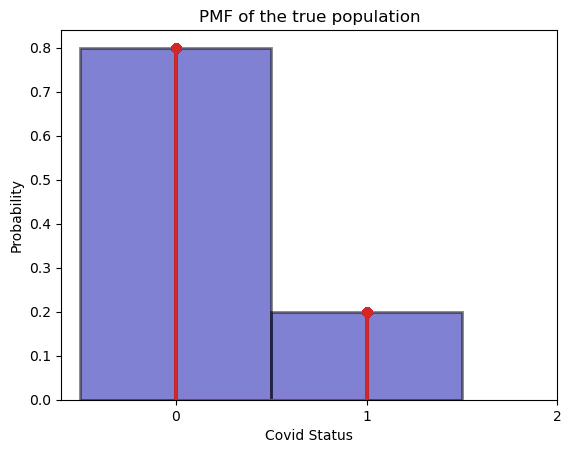

In [51]:
_ = plot_true_pmf(true_population)

The true pmf (ideal histogram) gives the answer that out of the true population, $80\%$ has no covid, and $20\%$ has covid.

So our PMF is realized:

$$
\begin{align}
\P(Y=y) = \begin{cases}
0.2  &\quad \text{ if } y=1 \\
0.8 &\quad \text{ if } y=0 \\
\end{cases}
\end{align}
$$

We can test it with `stats.bernoulli`.

In [52]:
p = 0.2
# `Y` is now an object that represents a Bernoulli random variable with parameter $p=0.2$.
Y = stats.bernoulli(0.2)

y = np.asarray([0, 1])  # {0, 1}

f = Y.pmf(y)

print(f)

[0.8 0.2]


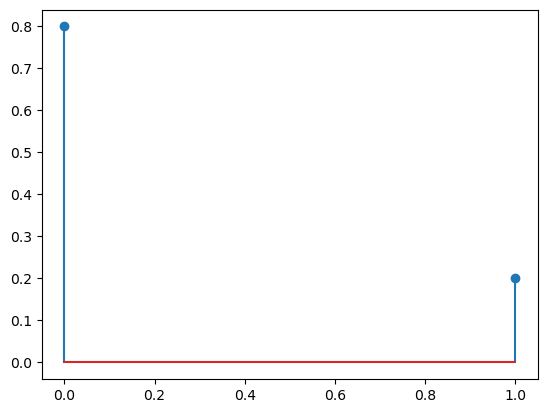

In [53]:
plt.stem(y, f);

The CDF is plotted below.

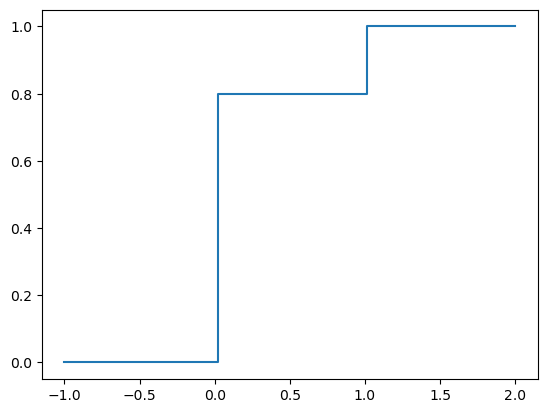

In [54]:
y = np.linspace(-1, 2, 101)
F = Y.cdf(y)
plt.step(y, F, where="post");

## Empirical Distribution (Empirical Histograms)

We are often given datasets from our stakeholders, be it 100 data points or 900 data points, we will not know if this number is truly
close to our true population.

But we want to prove a point, the ***convergence*** theory that if you have sufficiently large samples, then your empirical histogram/distribution
will tend to the true distribution/PMF. See {cite}`empirical_vs_pmf_2022`.

Let us draw samples of 1000, 5000 and 9000 to get the relative frequencies, and see if it indeed converges to our true distribution:

$$
\begin{align}
\P(Y=y) = \begin{cases}
0.2  &\quad \text{ if } y=1 \\
0.8 &\quad \text{ if } y=0 \\
\end{cases}
\end{align}
$$

In [55]:
# FIXME: unsure if replace=True or False here, but I read they are independent so it should be with replacement.
sample_1000 = np.random.choice(true_population, 1000, replace=True)
sample_5000 = np.random.choice(true_population, 5000, replace=True)
sample_9000 = np.random.choice(true_population, 9000, replace=True)

In [56]:
counter = 0
for i in sample_1000:
    if i == 0:
        counter += 1
print(counter) # ok surprisingly quite close..

795


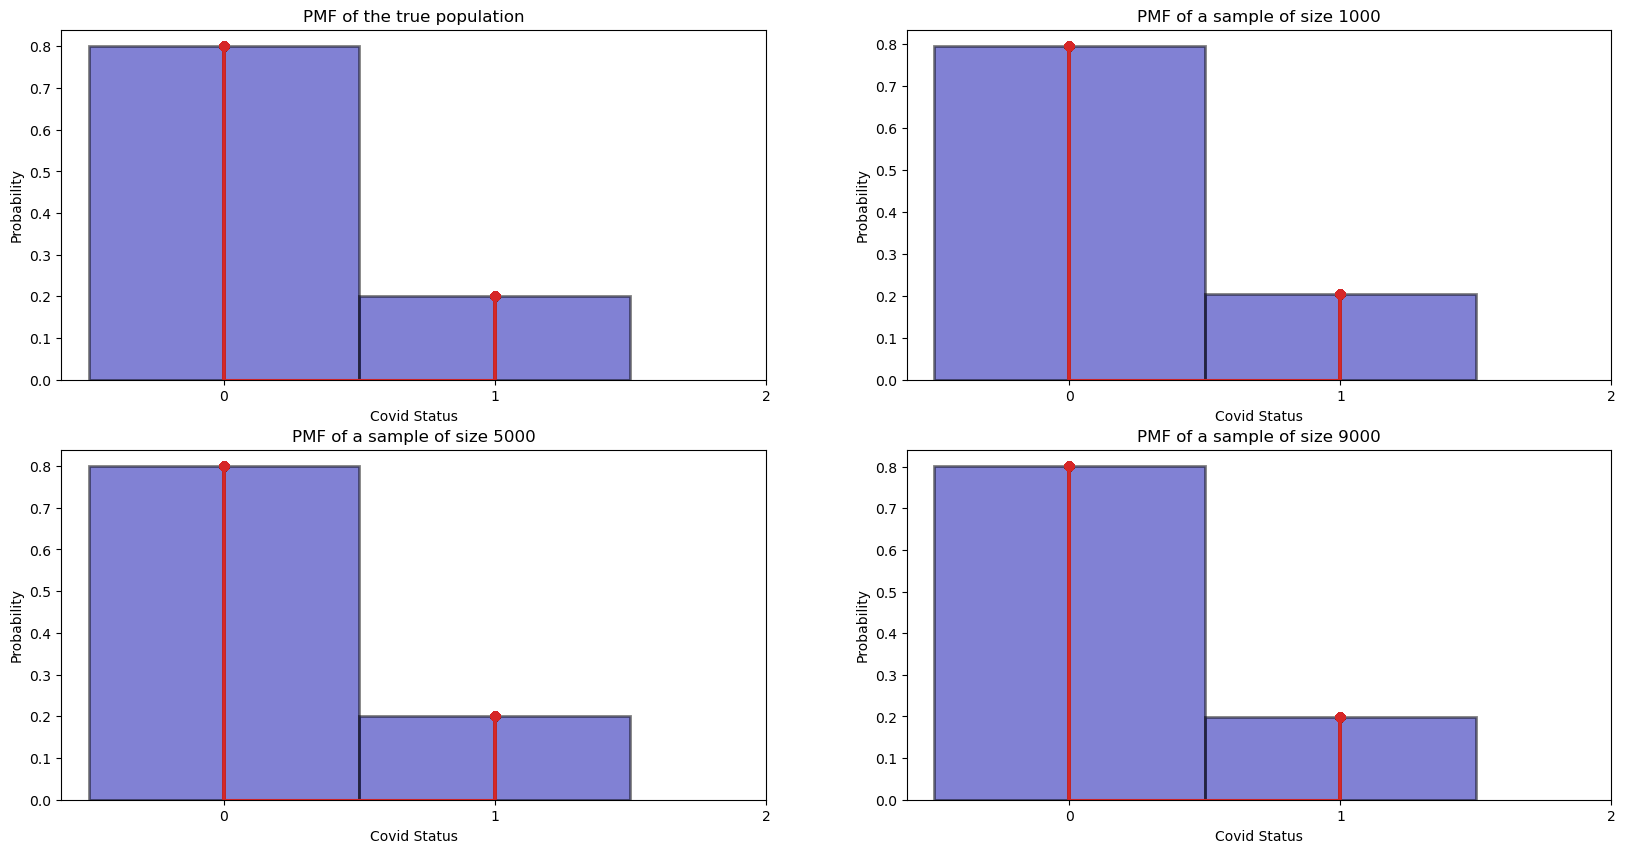

In [57]:
# ideal + empirical
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
bins = np.arange(0, true_population.max() + 1.5) - 0.5
axs[0, 0].hist(
    true_population,
    bins,
    density=True,
    color="#0504AA",
    alpha=0.5,
    edgecolor="black",
    linewidth=2,
)
axs[0, 0].stem(
    true_population,
    [true_pmf(x, true_population) for x in true_population],
    linefmt="C3-",
    markerfmt="C3o",
    basefmt="C3-",

)
axs[0, 0].set_title("PMF of the true population")
axs[0, 0].set_xlabel("Covid Status")
axs[0, 0].set_ylabel("Probability")
axs[0, 0].set_xticks(bins + 0.5)

axs[0, 1].hist(
    sample_1000,
    bins,
    density=True,
    color="#0504AA",
    alpha=0.5,
    edgecolor="black",
    linewidth=2,
)
axs[0, 1].stem(
    sample_1000,
    [empirical_pmf(x, sample_1000) for x in sample_1000],
    linefmt="C3-",
    markerfmt="C3o",
    basefmt="C3-",

)
axs[0, 1].set_title("PMF of a sample of size 1000")
axs[0, 1].set_xlabel("Covid Status")
axs[0, 1].set_ylabel("Probability")
axs[0, 1].set_xticks(bins + 0.5)

axs[1, 0].hist(
    sample_5000,
    bins,
    density=True,
    color="#0504AA",
    alpha=0.5,
    edgecolor="black",
    linewidth=2,
)
axs[1, 0].stem(
    sample_5000,
    [empirical_pmf(x, sample_5000) for x in sample_5000],
    linefmt="C3-",
    markerfmt="C3o",
    basefmt="C3-",

)
axs[1, 0].set_title("PMF of a sample of size 5000")
axs[1, 0].set_xlabel("Covid Status")
axs[1, 0].set_ylabel("Probability")
axs[1, 0].set_xticks(bins + 0.5)

axs[1, 1].hist(
    sample_9000,
    bins,
    density=True,
    color="#0504AA",
    alpha=0.5,
    edgecolor="black",
    linewidth=2,
)
axs[1, 1].stem(
    sample_9000,
    [empirical_pmf(x, sample_9000) for x in sample_9000],
    linefmt="C3-",
    markerfmt="C3o",
    basefmt="C3-",

)
axs[1, 1].set_title("PMF of a sample of size 9000")
axs[1, 1].set_xlabel("Covid Status")
axs[1, 1].set_ylabel("Probability")
axs[1, 1].set_xticks(bins + 0.5);

It is quite clear that as number of samples go up, the empirical histograms become more accurate. This is not surprisingly as intuitively, as your samples become large, your distribution will be more accurate to the true population.

Okay maybe not so clear as all 3 looks quite close :(

We can use `scipy.stats` as its random variables also has the ability to draw random values from the specified distribution (i.e., to get values of the random variable).  

The method to do this is called `rvs`. If it is called with no argument, then it generates a single value of that random variable {cite}`foundations_of_data_science_with_python_2021`.

In [59]:
Y.rvs() # 1 sample

0

In [60]:
Y.rvs(size=10) # 10 samples from the distribution

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In our case, we can do the same, 1000, 5000 and 9000 and plot them compared to the true distribution.

The relative freqs are [0.788 0.212]


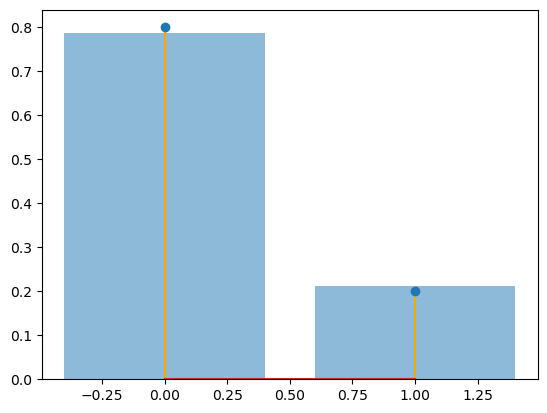

In [75]:
num_sims = 1000
y = Y.rvs(num_sims)
counts = np.asarray([list(y).count(0), list(y).count(1)]) # how many no covid vs covid

print(f"The relative freqs are {counts/num_sims}")
plt.bar([0, 1], counts / num_sims, alpha=0.5)
plt.stem([0, 1], Y.pmf([0, 1]), linefmt="orange");

The relative freqs are [0.7926 0.2074]


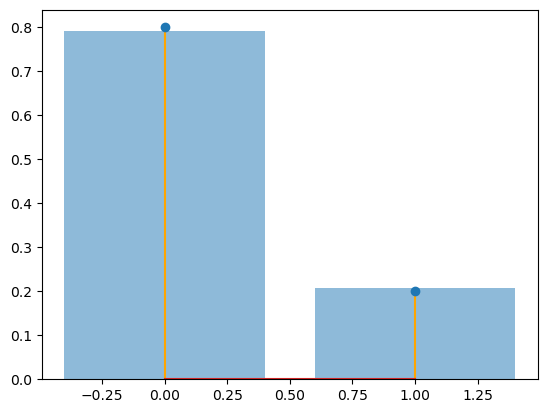

In [76]:
num_sims = 5000
y = Y.rvs(num_sims)
counts = np.asarray([list(y).count(0), list(y).count(1)]) # how many no covid vs covid

print(f"The relative freqs are {counts/num_sims}")
plt.bar([0, 1], counts / num_sims, alpha=0.5)
plt.stem([0, 1], Y.pmf([0, 1]), linefmt="orange");

The relative freqs are [0.80422222 0.19577778]


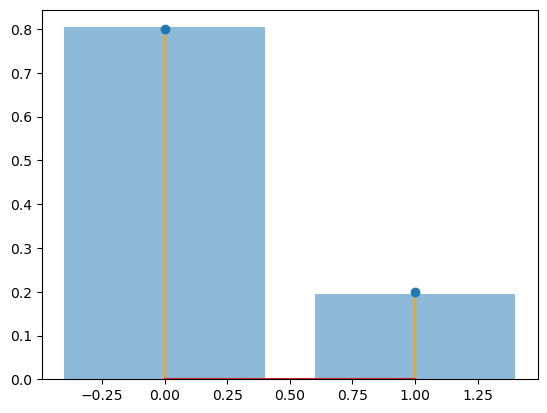

In [77]:
num_sims = 9000
y = Y.rvs(num_sims)
counts = np.asarray([list(y).count(0), list(y).count(1)]) # how many no covid vs covid

print(f"The relative freqs are {counts/num_sims}")
plt.bar([0, 1], counts / num_sims, alpha=0.5)
plt.stem([0, 1], Y.pmf([0, 1]), linefmt="orange");

## Bernoulli Sampling

- https://www.statisticshowto.com/bernoulli-trials/

One way is sample with replacement so samples are independent, but if sample size is large enough, sample without also converges.

## Logistic Regression

The Bernoulli distribution can be used to model the response of a logistic regression model conditionally. For example,
let $Y$ be 0 or 1, denoting if a person has covid. The predictors is the height and weight of the person.
Then $Y(y=1 | X = x)$ follows a Bernoulli distribution (conditional).

## References and Further Readings

- https://www.statisticshowto.com/bernoulli-trials/
- https://jmshea.github.io/Foundations-of-Data-Science-with-Python/08-random-variables/important-discrete-rvs.html#bernoulli-random-variable
- https://www.probabilitycourse.com/chapter3/3_1_5_special_discrete_distr.php
- https://bcheggeseth.github.io/Stat155Notes/bernoullibinomial-model.html
- https://www.youtube.com/watch?v=bT1p5tJwn_0&list=PLvxOuBpazmsNIHP5cz37oOPZx0JKyNszN&index=3